In [1]:
import numpy as np

Using TensorFlow backend.


(50000, 28, 28) (50000,)


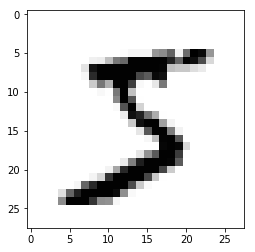

In [2]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [3]:
# Now that we've fixed our final model, let's add in cross-validation data to make it even better.

img_side = X_train.shape[1]

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])

X_train = np.reshape(X_train, (X_train.shape[0], img_side * img_side))
X_test = np.reshape(X_test, (X_test.shape[0], img_side * img_side))

In [4]:
def mask_y(y):
    mask = np.zeros((y.size, 10), dtype = "float32")
    for i, c in enumerate(y):
        mask[i][c] = 1
    return mask

In [5]:
import tensorflow as tf

tf.reset_default_graph()
session = tf.InteractiveSession()

In [6]:
input_X = tf.placeholder(tf.float32, shape = (None, img_side * img_side))
input_y = tf.placeholder(tf.float32, shape = (None, 10))

In [7]:
def build_network(layer_sizes, lmbda):
    global w, b, z, a, sm, loss
    w = []  # weights
    b = []  # biases
    z = []  # w * x + b
    a = []  # activations
    
    for i, (in_nodes, out_nodes) in enumerate(layer_sizes):
        xavier = (2.0 / (in_nodes + out_nodes)) ** 0.5
        
        w.append(tf.Variable(xavier * np.random.normal(size = (in_nodes, out_nodes)).astype("float32")))
        b.append(tf.Variable(0.01 * np.random.normal(size = (out_nodes,)).astype("float32")))
        
        z.append(tf.matmul(input_X if i == 0 else a[i-1], w[i]) + b[i])
        a.append(tf.sigmoid(z[i]))

    sm = tf.nn.softmax(a[-1])
    loss = -tf.reduce_mean(tf.reduce_sum(tf.log(sm) * input_y, axis = 1))
    loss += lmbda * sum([tf.nn.l2_loss(wi) for wi in w])

In [8]:
def train_network(X_train, y_train, X_test, y_test, batch_size, epochs):
    global w, b, sm, loss, input_X, input_y

    optimizer = tf.train.AdamOptimizer().minimize(loss, var_list = w + b)

    session.run(tf.global_variables_initializer())
    
    training_examples = X_train.shape[0]
    batches = training_examples // batch_size
    
    training_loss_path = []
    test_loss_path = []
    
    training_loss_path.append(session.run(loss, {input_X: X_train, input_y: mask_y(y_train)}))
    test_loss_path.append(session.run(loss, {input_X: X_test, input_y: mask_y(y_test)}))
    
    for epoch in range(epochs):
        perm = np.random.permutation(training_examples)
    
        X_batches = np.split(X_train[perm,:], batches)
        y_batches = np.split(mask_y(y_train)[perm,:], batches)
    
        for i in range(batches):
            session.run(optimizer, {input_X: X_batches[i], input_y: y_batches[i]})
        
        training_loss_path.append(session.run(loss, {input_X: X_train, input_y: mask_y(y_train)}))
        test_loss_path.append(session.run(loss, {input_X: X_test, input_y: mask_y(y_test)}))
    
    return training_loss_path, test_loss_path

In [9]:
build_network([(img_side * img_side, 500), (500, 10)], 1e-6)

from datetime import datetime

st = datetime.now()
training_loss_path, test_loss_path = train_network(X_train, y_train, X_test, y_test, 10, 20)
et = datetime.now()

In [10]:
print(et - st)

def accuracy(X, y, sm, input_X):
    pred = session.run(tf.argmax(sm, axis = 1), {input_X: X})
    return np.sum(pred == y) / y.shape

accuracy(X_test, y_test, sm, input_X)

0:04:10.019004


array([ 0.9795])

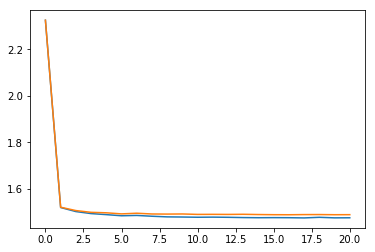

In [11]:
import matplotlib.pyplot

matplotlib.pyplot.plot(range(len(training_loss_path)), training_loss_path)
matplotlib.pyplot.plot(range(len(training_loss_path)), test_loss_path)